# Prediction: Tension Models
---
> Graph neural network model for vertex dynamics and tension prediction

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from os import path
import datetime

from torch_geometric.data import Data, DataLoader
import torch_geometric.transforms as T

from torch_geometric.utils import to_networkx, from_networkx
import networkx as nx
from simgnn.datautils import load_array, load_graph

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10,10) # use larger for presentation
matplotlib.rcParams['font.size']= 16 # use 14 for presentation

In [3]:
from collections import OrderedDict
from simgnn.datasets import persistence_loss, VertexDynamics, HaraMovies, HaraAblation
from simgnn.transforms import Pos2Vec, ScaleVelocity, ScaleTension, RecoilAsTension
from simgnn.transforms import AppendReversedEdges, AppendEdgeNorm, AppendDiff_x, Reshape_x
# from torch_geometric.utils import to_undirected as T_undir

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
dtype = torch.float32
print(f'Defaults:\n |-device: {device}\n |-dtype : {dtype}')

Defaults:
 |-device: cpu
 |-dtype : torch.float32


### Datasets

---
- **Normalisation param-s**

In [5]:
# Data normalisation param-s : sim="default" for simulation data
# Average edge lengths
l_0 = {'sim':1.0, 'single_distr_sims':1.1, 'unimodal_wbasetens_sims':0.91, 'hara':26.32, 'abln':50.13}

# Stat-s for raw tension/recoil values
t_av = {'sim':0.6, 'single_distr_sims': 0.58, 'unimodal_wbasetens_sims': 1.6, 'abln': 0.83}
t_sd = {'sim':0.63, 'single_distr_sims': 0.64, 'unimodal_wbasetens_sims':0.73 , 'abln': 0.65}

**Input features and normalisation param-s (transforms)**

In [6]:
# Input features
window_size = 5
print(f'> Set features window size to --> {window_size}')

# Simulation dataset
Tnrm = {k: [Pos2Vec(scale=10*l_0[k]) , ScaleVelocity(0.5*l_0[k]), ScaleTension(t_sd[k], shift=t_av[k])]
        for k in ['sim', 'single_distr_sims', 'unimodal_wbasetens_sims']}

# Hara ablation dataset
Tnrm['abln'] = [Pos2Vec(scale=10*l_0['abln']), ScaleVelocity(0.5*l_0['abln']),
                RecoilAsTension(), ScaleTension(t_sd['abln'], shift=t_av['abln'])]

# Hara movie dataset
Tnrm['hara'] = [Pos2Vec(scale=10*l_0['hara']) , ScaleVelocity(0.5*l_0['hara'])]

# Node and Edge Feature Transforms
for k in Tnrm:
    # to undirected graph: add e_ji for all e_ij
    Tnrm[k].append(AppendReversedEdges())
    
    # Add edge features
    Tnrm[k].append(AppendDiff_x())
    Tnrm[k].append(AppendEdgeNorm())
    
    # flatten  node features
    Tnrm[k].append(Reshape_x((-1,window_size*2)))
    
    Tnrm[k] = T.Compose(Tnrm[k])

> Set features window size to --> 5


**Load datasets**

- if a new `w` parameter is set, delete the older *processed* dataset files

In [7]:
!rm -dr simgnn_data/single_distr_sims/train/processed
!rm -dr simgnn_data/single_distr_sims/val/processed
!rm -dr simgnn_data/unimodal_wbasetens_sims/train/processed
!rm -dr simgnn_data/unimodal_wbasetens_sims/val/processed

!rm -dr simgnn_data/hara_movies/processed/
!rm -dr simgnn_data/hara_ablation/processed/

# !rm -dr simgnn_data/hara_movies_as_sep_datasets/hara_seg001/processed/
# !rm -dr simgnn_data/hara_movies_as_sep_datasets/hara_seg003/processed/
# !rm -dr simgnn_data/hara_movies_as_sep_datasets/hara_seg005/processed/

In [8]:
hara_abln = HaraAblation('simgnn_data/hara_ablation/', window_size=window_size, transform=Tnrm['abln'], smoothing=True, sma_lag_time=3)
hara = HaraMovies('simgnn_data/hara_movies/',window_size=window_size, transform=Tnrm['hara'], smoothing=True, sma_lag_time=4)

# Hara movie datasets
# seg001 = HaraMovies('simgnn_data/hara_movies_as_sep_datasets/hara_seg001/', window_size=window_size, transform=Tnorm_hara,smoothing=True, sma_lag_time=4)
# seg001_raw = HaraMovies('simgnn_data/hara_movies/', window_size=window_size, transform=Tnorm_hara)
# seg003 = HaraMovies('simgnn_data/hara_movies_as_sep_datasets/hara_seg003/', window_size=window_size, transform=Tnorm_hara,smoothing=True, sma_lag_time=4)
# seg005 = HaraMovies('simgnn_data/hara_movies_as_sep_datasets/hara_seg005/', window_size=window_size, transform=Tnorm_hara,smoothing=True, sma_lag_time=4)

# Simulation datasets
# rand base contractility
sim1 = VertexDynamics('./simgnn_data/unimodal_wbasetens_sims/train/', window_size=window_size,
#                       transform=Tnrm['sim']
                      transform=Tnrm['unimodal_wbasetens_sims']
                     )
sim1_val = VertexDynamics('./simgnn_data/unimodal_wbasetens_sims/val/', window_size=window_size,
#                           transform=Tnrm['sim']
                          transform=Tnrm['unimodal_wbasetens_sims']
                         )

# w/o base contractility
sim2 = VertexDynamics('./simgnn_data/single_distr_sims/train/', window_size=window_size,
#                       transform=Tnrm['sim']
                      transform=Tnrm['single_distr_sims']
                     )
sim2_val = VertexDynamics('./simgnn_data/single_distr_sims/val/', window_size=window_size,
#                           transform=Tnrm['sim']
                          transform=Tnrm['single_distr_sims']
                         )


datasets_dict = {'train': sim1,
                 'val': sim1_val,
                 'val2': sim2_val,
                 'hara' : hara,
                 'abln': hara_abln}
dataset_legend={'train': 'Train(sim1)',
                'val': 'Val(sim1)',
                'val2': 'Val(sim2)',
                'hara': 'Hara',
                'abln': 'Recoil'}

Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!


In [9]:
# k = 'val2'
# t = 15
# print('{}\n{} : {}\nsize:{}\n\nFrame {}:\n{}'.format(dataset_legend[k],k,datasets_dict[k],len(datasets_dict[k]),t,datasets_dict[k][0]))
# plt.figure(figsize=[2.5,2.5])
# nx.draw(to_networkx(datasets_dict[k][t]),pos=dict(enumerate(datasets_dict[k][t].pos.numpy())), node_size=10)

## Load Trained Model

In [10]:
from simgnn.train import train_model, load_log, plot_losses

# from simgnn.nn import mlp, IndependentBlock, MessageBlock, dims_to_dict, Encode_Process_Decode
from simgnn.models import construct_simple_gnn, GraphEncoder, GraphDecoder, GraphProcessor

In [11]:
import simgnn.hardcoded as hcmodels # hardcoded models for testing and experimentation

In [12]:
# # # # Load Saved Model:
model_dir = './simgnn_data/saved_models/tension_test'
model_fname = '07122021_202217_model_04122021_bs2w5'
train_log = load_log(path.join(model_dir,
                               '07122021_202217_model_04122021_bs2w5'+'_train_log.pkl'))

net = hcmodels.get_model_04122021().to(device)
net.load_state_dict(torch.load(path.join(model_dir, '07122021_202217_model_04122021_bs2w5'+'_net.pkl'),
                               map_location=device))

<All keys matched successfully>

## Plot Predictions

In [16]:
from simgnn.train import predict, predict_batch, plot_velocity_predictions, plot_tension_prediction
from simgnn.train import predict_abln_tension, predict_dataset_tension

from scipy.stats import pearsonr

- train_loss_tot =0.10297732874342899;
- train_loss_y =0.003477566253032687;
- train_loss_T =0.0994997624903963;
- val_loss_tot =0.4870912311526814;
- val_loss_y =0.003581976608359798;
- val_loss_T =0.4835092545443216;
- val2_loss_tot =0.5524204886911175;
- val2_loss_y =0.0034829389810914825;
- val2_loss_T =0.548937549710026;
- hara_loss_tot =0.0017546781655478892;
- hara_loss_y =0.0017546781655478892;
- hara_loss_T =0.0;



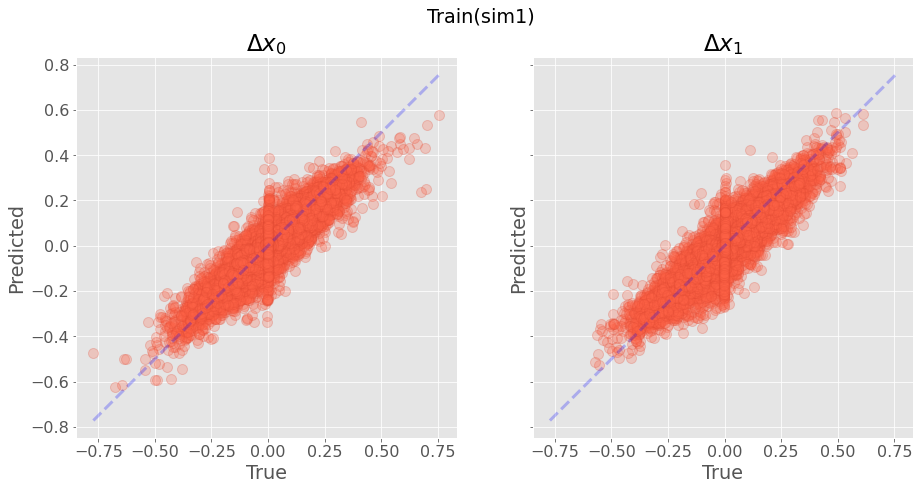

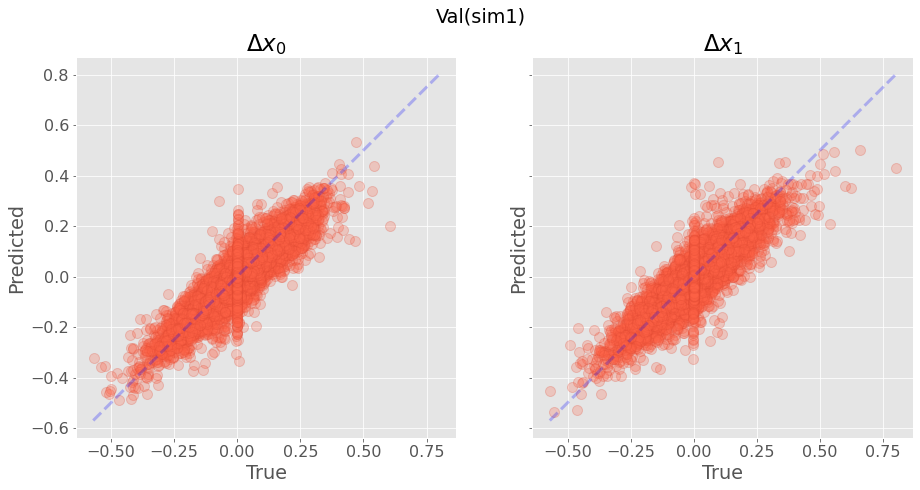

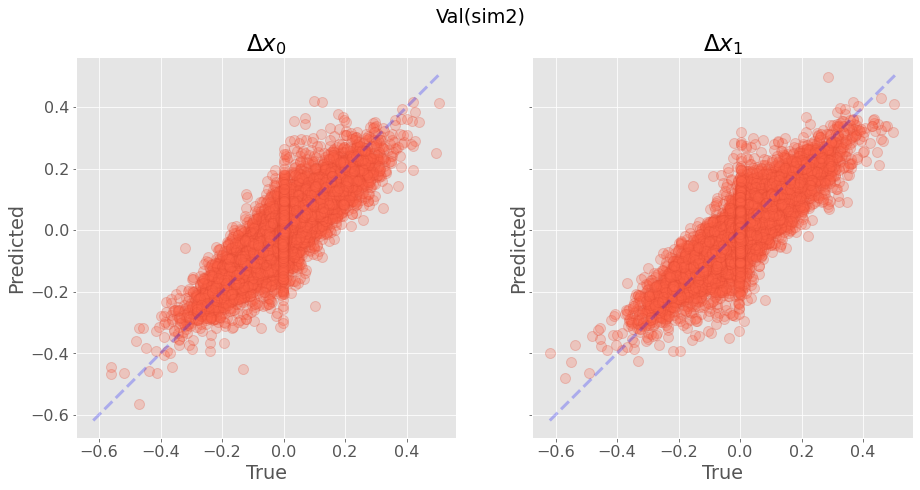

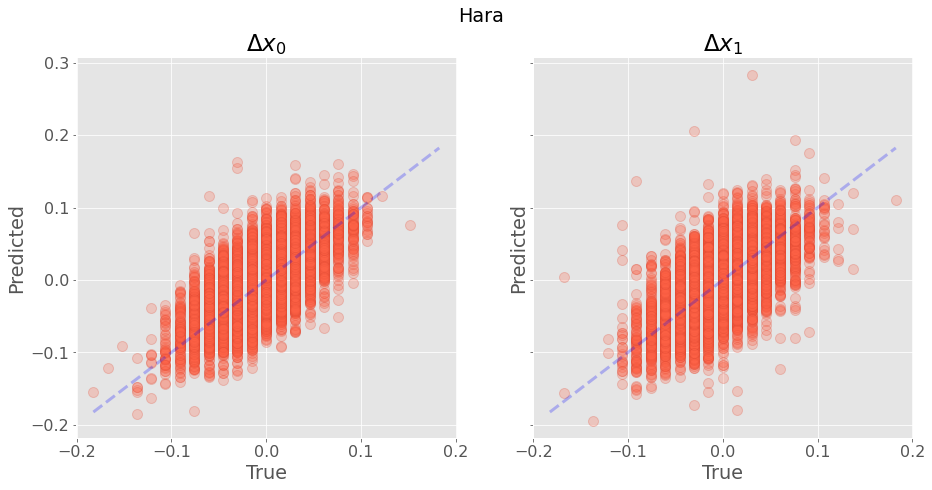

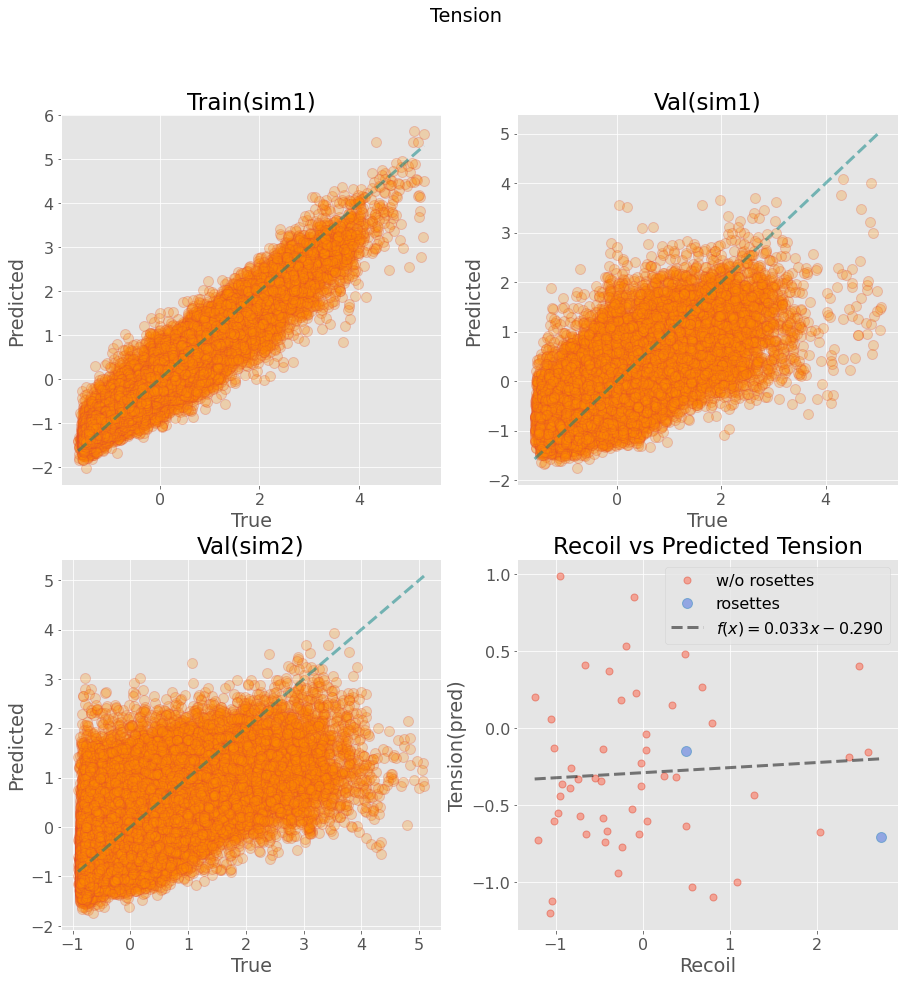

- - - - - - - - - - -
NO___rosettes :
	R,p=(0.06190856029448798, 0.6628400915969175)
WITH_rosettes :
	R,p=(0.01632933838001589, 0.906705025998268)
- - - - - - - - - - -


In [17]:
# compute predictions and plot them
# vel-y, tens, pres
bs = 2

pred_out, tgt_out, sample_losses = predict_batch(net,
                                                 {
                                                  'train' : DataLoader(datasets_dict['train'], batch_size=bs),
                                                  'val':    DataLoader(datasets_dict['val'],  batch_size=bs),
                                                  'val2':   DataLoader(datasets_dict['val2'], batch_size=bs),
                                                  'hara':   DataLoader(datasets_dict['hara'], batch_size=bs)},
                                                 loss_func=torch.nn.MSELoss(reduction='sum'),
                                                 use_force_loss = {'train': True, 'val': True, 'val2': True, 'hara': False},
                                                 return_losses = True, device=device)
print(''.join([f'- {k} ={sample_losses[k]};\n' for k in sample_losses]))

plot_velocity_predictions(pred_out[0], tgt_out[0], dataset_legend)

axs = plot_tension_prediction(pred_out[1], tgt_out[1], dataset_legend,figsize=[15,15],nrows=2,ncols=2)

# # # # # # # # # # # # # #
# # # Hara Ablation # # # #
# # # # # # # # # # # # # #
Tp, Tt, is_ros_ = predict_abln_tension(net, datasets_dict['abln'], device=device)

m1,m2 = np.polyfit(Tt[~is_ros_], Tp[~is_ros_], 1)
y_fit = np.array([min(Tt),max(Tt)])*m1+m2

# plt.figure(figsize=[6,6])
ax = axs.ravel()[-1]
ax.plot(Tt[~is_ros_], Tp[~is_ros_], 'o', mfc='tomato', ms=7, alpha=.5, label='w/o rosettes')
ax.plot(Tt[is_ros_], Tp[is_ros_], 'o', mfc='royalblue', ms=10, alpha=.5, label='rosettes')

ax.plot([min(Tt),max(Tt)], y_fit, 'k--',lw=3, alpha=.5, label=f'$f(x)={m1:.3f}x{"+" if m2>0 else "-"}{np.abs(m2):.3f}$')
ax.legend();
ax.set_title('Recoil vs Predicted Tension');
ax.set_xlabel('Recoil');
ax.set_ylabel('Tension(pred)');
ax.legend();

plt.show()
print('- '*10+'-')
print(f'NO___rosettes : R,p={pearsonr(Tt[~is_ros_], Tp[~is_ros_])}')
print(f'WITH_rosettes : R,p={pearsonr(Tt, Tp)}')
print('- '*10+'-')

---

**Check tension prediction, losses, and plots**

train MSE: 0.09949976225302459
val MSE: 0.48350925809452844
val2 MSE: 0.5489375508429921


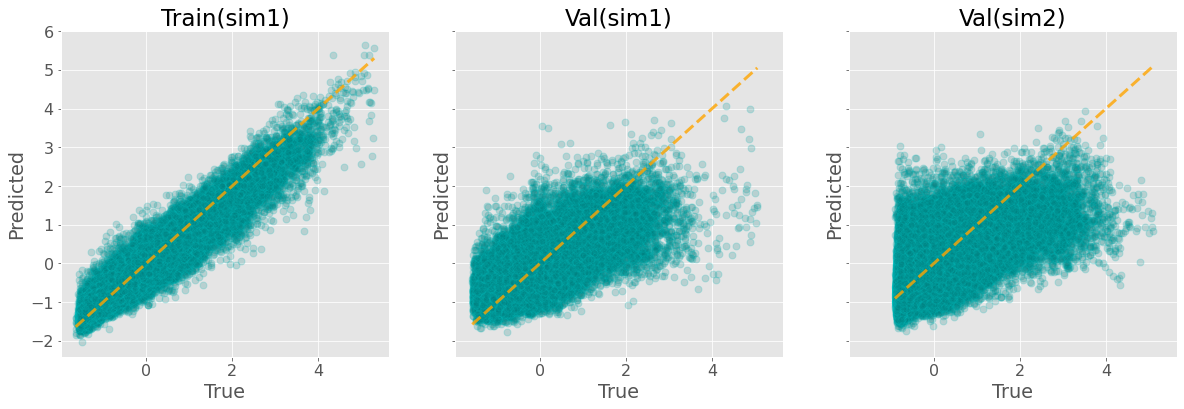

In [14]:
# # Predict for each sample w/o batching:

_, axs = plt.subplots(ncols=3, figsize=[20, 6], sharex=True, sharey=True)

tension_preds = {}
tension_trues = {}

for dataset_k, ax in zip(['train', 'val', 'val2'], axs):
    Tp, Tt =  predict_dataset_tension(net, datasets_dict[dataset_k],device=device)
    tension_preds[dataset_k] = Tp
    tension_trues[dataset_k] = Tt

    minmaxY = [np.min(np.concatenate([k.ravel() for k in Tt])),
               np.max(np.concatenate([k.ravel() for k in Tt]))] 

    ax.plot(np.concatenate([k.ravel() for k in Tt]),
            np.concatenate([k.ravel() for k in Tp]),
            'o', ms=7, c='c', mfc='teal', alpha=.2)
    ax.plot(minmaxY, minmaxY, '--', color='orange', lw=3, alpha=.8)
    ax.set_title(dataset_legend[dataset_k]);
    ax.set_xlabel('True')
    ax.set_ylabel('Predicted')
    
    sum_l2_losses, Nsamples = np.array([(((Tp_k-Tt_k)**2).sum(), Tp_k.shape[1])
                                    for Tp_k, Tt_k in zip(tension_preds[dataset_k], tension_trues[dataset_k])]).sum(axis=0)
    print(f'{dataset_k} MSE:', sum_l2_losses/Nsamples)

In [90]:
# Tp_y = np.concatenate([Tp_k.ravel() for Tp_k in tension_preds['val']])
# Tt_x = np.concatenate([Tp_k.ravel() for Tp_k in tension_trues['val']])
# SE_val = (Tp_y - Tt_x)**2

# plt.plot(Tt_x[(SE_val>5)&(SE_val<10)], Tp_y[(SE_val>5)&(SE_val<10)], 'ro', ms=10, alpha=.5, label='SE=5:10')
# plt.plot(Tt_x[(SE_val>10)&(SE_val<15)], Tp_y[(SE_val>10)&(SE_val<15)], 'mo', ms=10, alpha=.5, label='SE=10:15')
# plt.plot(Tt_x[(SE_val>15)], Tp_y[(SE_val>15)], 'o', c='deeppink', ms=10, alpha=.5, label='SE>15')

# plt.plot([-1,5], [-1,5], '--', color='orange', lw=3, alpha=.8)
# plt.legend();

# # for k,(x,y) in enumerate(zip(, Tp_y)):
# # if SE_val[k]>5 and :
# # plt.plot(x,y, 'ro', ms=10)
# # elif SE_val[k]>10 and SE_val[k]<15:
# # 
# # elif SE_val[k]>15:
# # plt.plot(x,y, 'yo', ms=10)
# # else:
# # plt.plot(x,y, 'bo', ms=10)

In [94]:
dataset_k = 'val'
sim_name_list = [k.split('_')[2] for k in datasets_dict[dataset_k].processed_file_names]
sim_names = {k : ki for ki, k in enumerate(np.unique(sim_name_list))}
sim_name_idx = torch.tensor([sim_names[k] for k in sim_name_list])



tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [95]:
torch.unique(sim_name_idx)

tensor([0, 1])

In [ ]:
# lenij_mov_k = np.concatenate([torch.linalg.norm(d.pos[d.edge_index[1]] - d.pos[d.edge_index[0]], axis=1).numpy().reshape(1,-1) for d in mov_k],axis=0)
# dLdt = np.diff(lenij_mov_k,axis=0)
# print('lenij_mov_k', lenij_mov_k.shape)

# for k in [10,20,25,30,50]:
#     plt.plot(lenij_mov_k[:,k])

In [36]:
datasets_dict['val'][sim_name_idx==sim_names['sim005']]

VertexDynamics(56)

In [42]:
len(tension_preds['val'])

112

In [15]:
dataset_k = 'train'

l2_loss = torch.nn.MSELoss(reduction='mean')
print('torch.nn.MSE:', l2_loss(torch.from_numpy(np.concatenate([T_k.ravel() for T_k in tension_trues[dataset_k]])),
                               torch.from_numpy(np.concatenate([T_k.ravel() for T_k in tension_preds[dataset_k]]))) )

torch.nn.MSE: tensor(0.0995)
